## Data Augmentation

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import PIL
from torchsummary import summary

In [ ]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

In [ ]:
RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 40
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((16, 16)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(degrees=30, interpolation=PIL.Image.BILINEAR),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = torchvision.transforms.Compose([
      torchvision.transforms.Resize((16, 16)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



train_loader_augmented, valid_loader_augmented, test_loader_augmented = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1306: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [ ]:
class CNN1(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2) #output 8 / 2 => output 4
    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(32*4*4, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model1_augmented = CNN1(num_classes=10)

In [ ]:
model1_augmented = model1_augmented.to(DEVICE)

In [ ]:
print(summary(model1_augmented, (3, 16, 16)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              ReLU-2           [-1, 16, 16, 16]               0
         MaxPool2d-3             [-1, 16, 8, 8]               0
            Conv2d-4             [-1, 32, 8, 8]           2,080
              ReLU-5             [-1, 32, 8, 8]               0
         MaxPool2d-6             [-1, 32, 4, 4]               0
            Linear-7                  [-1, 100]          51,300
              ReLU-8                  [-1, 100]               0
            Linear-9                   [-1, 10]           1,010
Total params: 54,838
Trainable params: 54,838
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.21
Estimated Total Size (MB): 0.32
---------------------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


In [ ]:
optimizer_augmented = torch.optim.SGD(model1_augmented.parameters(), lr=0.1)
scheduler_augmented = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_augmented,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list_augmented1, train_acc_list_augmented1, valid_acc_list_augmented1 = train_model(
    model=model1_augmented,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader_augmented,
    valid_loader=valid_loader_augmented,
    test_loader=test_loader_augmented,
    optimizer=optimizer_augmented,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

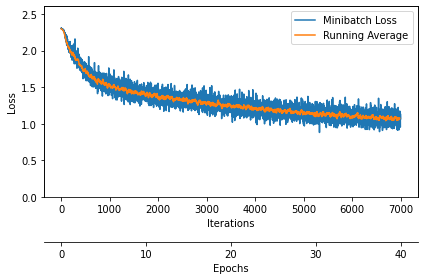

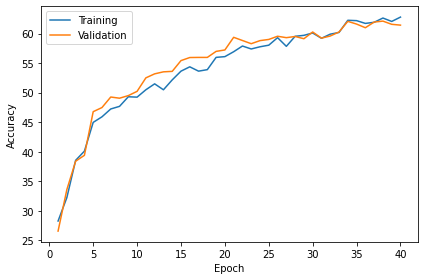

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list_augmented1,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader_augmented),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list_augmented1,
              valid_acc_list=valid_acc_list_augmented1,
              results_dir=None)

# plt.ylim([80, 100])
plt.show()










In [ ]:
class CNN2(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), #output 8 / 2 => output 4

            # Conv 3
            torch.nn.Conv2d(32, 64, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 4
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2) #output 4 / 2 => output 2

    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(64*2*2, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model2_augmented = CNN2(num_classes=10)

In [ ]:
model2_augmented = model2_augmented.to(DEVICE)

In [ ]:
print(summary(model2_augmented, (3, 16, 16)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              ReLU-2           [-1, 16, 16, 16]               0
         MaxPool2d-3             [-1, 16, 8, 8]               0
            Conv2d-4             [-1, 32, 8, 8]           2,080
              ReLU-5             [-1, 32, 8, 8]               0
         MaxPool2d-6             [-1, 32, 4, 4]               0
            Conv2d-7             [-1, 64, 4, 4]           8,256
              ReLU-8             [-1, 64, 4, 4]               0
         MaxPool2d-9             [-1, 64, 2, 2]               0
           Linear-10                  [-1, 100]          25,700
             ReLU-11                  [-1, 100]               0
           Linear-12                   [-1, 10]           1,010
Total params: 37,494
Trainable params: 37,494
Non-trainable params: 0
---------------------------------

In [ ]:
optimizer_augmented2 = torch.optim.SGD(model2_augmented.parameters(), lr=0.1)
scheduler_augmented2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_augmented2,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list_augmented2, train_acc_list_augmented2, valid_acc_list_augmented2 = train_model(
    model=model2_augmented,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader_augmented,
    valid_loader=valid_loader_augmented,
    test_loader=test_loader_augmented,
    optimizer=optimizer_augmented2,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

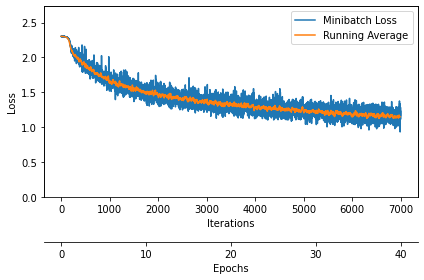

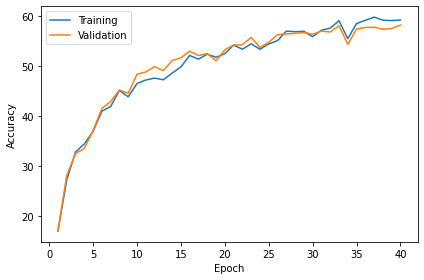

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list_augmented2,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader_augmented),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list_augmented2,
              valid_acc_list=valid_acc_list_augmented2,
              results_dir=None)

# plt.ylim([80, 100])
plt.show()





























In [ ]:
import pandas as pd

In [ ]:
results = pd.DataFrame({"Number of Parameters": [54838, 37494], "Accuracy": [63, 59]}, index = ["CNN1", "CNN2"])

In [ ]:
results

,Number of Parameters,Accuracy
CNN1,54838,63
CNN2,37494,59


## Even with data augmentation the simpler CNN works better as there are more pixels to work with.